In [1]:
from __future__ import print_function, division
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import json
cudnn.benchmark = True
plt.ion()   # interactive mode

/home/dzhang/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(384),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(438),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset = torchvision.datasets.Food101(root="/home/dzhang/home/dzhang/efficientnet/data", download=False, transform=data_transforms['train'])

In [14]:

def get_class_distribution(dataset, subset):
    train_classes = [dataset.__getitem__(i)[1] for i in subset.indices]
    print(Counter(train_classes)) # if doesn' work: Counter(i.item() for i in train_classes)
    
def make_subset(dataset, num_classes):
    idx = [i for i in range(len(dataset)) if dataset.__getitem__(i)[1] in range(num_classes)]
    return Subset(dataset, idx)

def get_idx(dataset, n):
    idx_dict = {}
    for i in range(len(dataset)):
        label = dataset.__getitem__(i)[1]
        if label in range(n):
            if label in idx_dict:
                idx_dict[label].append(i)
            else:
                idx_dict[label] = [i]
        if i % 2000 == 0:
            print(i)
    return idx_dict
    
def get_label_name(dataset, i):
    class_swap = {v:k for k, v in dataset.class_to_idx.items()}
    return class_swap[i]
    
def get_shortened_idx(idx_dict, shortened_class, val_split_regular, val_split_minority, amount_to_discard, test_size=.2):
    new_dict = {}
    train_idx = []
    val_idx = []
    test_idx = []
    for k, v in idx_dict.items():
        if k != shortened_class:
            class_i_train, class_i_test = train_test_split(v, test_size=test_size)
            class_i_train, class_i_val = train_test_split(class_i_train, test_size=val_split_regular)
            train_idx += class_i_train
            val_idx += class_i_val
            test_idx += class_i_test
    shortened_list = idx_dict[shortened_class][amount_to_discard:] # replace with random sampling and tracking the discarded indices later. Just throws away first n samples for now
    minority_train, minority_val = train_test_split(shortened_list, test_size=val_split_minority)
    train_idx += minority_train
    val_idx += minority_val
    discarded_idx = idx_dict[shortened_class][:amount_to_discard] 
    test_idx += discarded_idx[:int(round(750*test_size))]
    
    split_idx = {}
    split_idx['train'] = train_idx
    split_idx['val'] = val_idx
    split_idx['discarded'] = idx_dict[shortened_class][:amount_to_discard] # the discarded ids
    split_idx['test'] = test_idx # 
    return split_idx

def train_val_split_idx(dataset, idx):
    datasets = {}
    datasets['train'] = Subset(dataset, idx['train'])
    datasets['val'] = Subset(dataset, idx['val'])
    datasets['test'] = Subset(dataset, idx['test'])
    return datasets

def get_dataloaders(datasets, batch_size):
    train_dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)

    val_dataloader = DataLoader(datasets['val'], batch_size=batch_size, shuffle =True)

    test_dataloader = DataLoader(datasets['test'], batch_size=batch_size, shuffle =True)
    dataloaders = {}

    dataloaders['train'] = train_dataloader
    dataloaders['val'] = val_dataloader
    dataloaders['test'] = test_dataloader
    return dataloaders

def keystoint(x):
    return {int(k): v for k, v in x.items()}

def load_idx_dict(dataset, n, retrace=False):
    if retrace:
        return get_idx(dataset, n)
    else:
        print("loading idx from idx.json")
        idx_file = open("idx.json", "r")
        json_dict = idx_file.read()
        idx_dict = json.loads(json_dict, object_hook=keystoint)
        idx_file.close()
        return idx_dict
        
def train_val_full_dataset(dataset, val_split = .25, test_size = .2):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_size)
    train_idx, val_idx = train_test_split(train_idx, test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    datasets['test'] = Subset(dataset, test_idx)
    return datasets

In [15]:
# idx_file = open("idx.json", "w")
# json.dump(idx_dict, idx_file)

# def keystoint(x):
#     return {int(k): v for k, v in x.items()}

# idx_file = open("idx.json", "r")
# json_dict = idx_file.read()
# idx_dict = json.loads(json_dict, object_hook=keystoint)
# idx_file.close()

idx_dict = load_idx_dict(dataset, 6)


loading idx from idx.json


Feature batch shape: torch.Size([32, 3, 384, 384])
Labels batch shape: torch.Size([32])


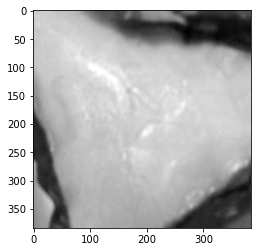

Label: 2
torch.Size([32, 3, 384, 384])
Counter({4: 450, 0: 450, 1: 450, 2: 450, 3: 450, 5: 93})
Counter({4: 150, 0: 150, 1: 150, 2: 150, 3: 150, 5: 32})
Counter({4: 150, 0: 150, 1: 150, 2: 150, 3: 150, 5: 150})


In [17]:
train_val_idx = get_shortened_idx(idx_dict, 5, .25, .25, 625) # making minority class (class 5) with 625 thrownaway points of data as training. 125 images vs 600. Both have .75 train validation split. All thrownaway points are put in test 

datasets = train_val_split_idx(dataset, train_val_idx) # making subsets from idx above

batch_size = 32

dataloaders = get_dataloaders(datasets=datasets, batch_size=batch_size)


def get_dataloader_shapes_distribution(dataloaders, datasets):
    train_features, train_labels = next(iter(dataloaders['train']))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    # print(f"Feature batch: {train_features}")
    # print(f"Labels batch: {train_labels}")
    img = train_features[0].squeeze()
    img = img[0, :, :]
    label = train_labels[0]
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")
    print(train_features.shape)
    get_class_distribution(dataset, datasets['train'])
    get_class_distribution(dataset, datasets['val'])
    get_class_distribution(dataset, datasets['test'])

get_dataloader_shapes_distribution(dataloaders, datasets)

Feature batch shape: torch.Size([32, 3, 384, 384])
Labels batch shape: torch.Size([32])


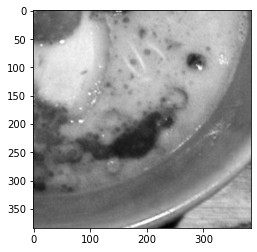

Label: 81
torch.Size([32, 3, 384, 384])
Counter({23: 482, 0: 475, 24: 474, 71: 473, 84: 473, 11: 472, 54: 472, 48: 471, 79: 471, 66: 470, 83: 469, 25: 468, 30: 468, 12: 467, 47: 467, 81: 467, 59: 466, 9: 464, 26: 464, 68: 463, 69: 463, 77: 462, 21: 462, 8: 461, 97: 461, 6: 461, 34: 461, 46: 460, 98: 460, 14: 459, 78: 459, 65: 459, 35: 459, 93: 459, 52: 457, 4: 457, 7: 457, 60: 456, 57: 456, 33: 455, 75: 454, 29: 454, 38: 453, 1: 452, 43: 451, 91: 451, 94: 451, 53: 451, 42: 450, 49: 449, 37: 449, 86: 449, 36: 449, 92: 448, 87: 448, 10: 448, 45: 446, 28: 445, 88: 445, 82: 445, 99: 445, 100: 445, 73: 444, 76: 444, 18: 444, 96: 444, 85: 444, 20: 443, 95: 442, 44: 442, 3: 442, 41: 442, 70: 442, 5: 441, 2: 441, 31: 440, 17: 440, 15: 439, 51: 439, 19: 437, 89: 437, 62: 436, 50: 436, 74: 436, 16: 436, 61: 436, 56: 435, 13: 434, 63: 434, 72: 434, 32: 433, 64: 432, 90: 432, 58: 432, 27: 430, 80: 429, 39: 428, 67: 424, 22: 420, 55: 417, 40: 411})
Counter({40: 186, 55: 170, 85: 169, 88: 167, 89: 1

In [54]:
# for loading and training on full untrimmed set

full_datasets = train_val_full_dataset(dataset)

full_dataloaders = get_dataloaders(datasets=full_datasets, batch_size=batch_size)

# get_dataloader_shapes_distribution(full_dataloaders, full_datasets)

In [19]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()

  def forward(self, x):
    return x

def fit_efficientnet_shape(n):
    # fitting efficientnet shape 
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.efficientnet_v2_s(pretrained=False, weights=None)
    # print(model)

  
    # removing avg pool layer 
    model.avgpool = Identity()
    # model.features.avgpool = Identity()
    model.classifier = nn.Linear(184320,n)

    model.to(device)
    return model
    # print(model)

In [ ]:
# fitting efficientnet shape 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.efficientnet_v2_s(pretrained=False, weights=None)
# print(model)

class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  
  def forward(self, x):
    return x

# removing avg pool layer 
model.avgpool = Identity()
# model.features.avgpool = Identity()
model.classifier = nn.Linear(184320,6)

model.to(device)
# print(model)

In [21]:
# Hyperparameters
num_classes = 6
learning_rate = 2e-6
num_epochs = 25
load_model = False
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

def make_criterion_optimizer(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    return criterion, optimizer

# saving and loading model
def save_checkpoint(state, filename="efficientnet_checkpoint.pth.tar"):
    print("Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(model, optimizer, filename="/home/dzhang/home/dzhang/efficientnet/efficientnet_checkpoint.pth.tar"):
    print("loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
# # train_features = train_features.to(device)
# outputs = model(train_features)
# # print(preds.shape)
# print(train_labels.shape)

# x, preds = torch.max(outputs, 1)
# print(preds.shape)
# print(preds)
# print(train_labels)



In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_criterion_optimizer(data, load=True):
    if data == 'trimmed':
        model = fit_efficientnet_shape(6)
        criterion, optimizer = make_criterion_optimizer(model)
        if load:
            load_checkpoint(model=model, optimizer=optimizer)
        return model, criterion, optimizer    
    

model, criterion, optimizer = load_model_criterion_optimizer(data='trimmed')

# load_checkpoint()

loading checkpoint


In [23]:
def change_lr(optimizer, learning_rate):
    for g in optimizer.param_groups:
        g['lr'] = learning_rate


In [24]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
              
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


def eval_model(model, dataloaders, nb_classes):
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                # display images or save sample idx that model incorrectly predicts here
                confusion_matrix[t.long(), p.long()] += 1
    print('Confusion matrix: ')
    print(confusion_matrix)
    print('Accuracy by class: ')
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    

    

In [25]:
# change_lr(optimizer, 1e-8)

train_val_idx = get_shortened_idx(idx_dict, 5, .25, .25, 625) # making minority class (class 5) with 625 thrownaway points of data as training. 125 images vs 600. Both have .75 train validation split. All thrownaway points are put in test 

datasets = train_val_split_idx(dataset, train_val_idx) # making subsets from idx above

batch_size = 32

dataloaders = get_dataloaders(datasets=datasets, batch_size=batch_size)

model, criterion, optimizer = load_model_criterion_optimizer(data='trimmed')

load_checkpoint(model, optimizer)


# best_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=100) # returns model weights that achieve best validation accuracy 

loading checkpoint
loading checkpoint


In [27]:
# eval_model(model, dataloaders, num_classes)

eval_model(model, dataloaders, num_classes)

Confusion matrix: 
tensor([[110.,   7.,  26.,   2.,   5.,   0.],
        [ 16., 120.,   9.,   1.,   4.,   0.],
        [ 26.,   7., 108.,   3.,   5.,   1.],
        [  2.,   8.,   4., 120.,  15.,   1.],
        [ 11.,   7.,   4.,  12., 116.,   0.],
        [  9.,  17.,   9.,  32.,  36.,  47.]])
Accuracy by class: 
tensor([0.7333, 0.8000, 0.7200, 0.8000, 0.7733, 0.3133])


In [96]:

checkpoint = {'state_dict' : best_model[0].state_dict(), 'optimizer' : optimizer.state_dict()}
save_checkpoint(state=checkpoint)

Saving checkpoint


In [71]:
# for loading and training on full untrimmed set

full_datasets = train_val_full_dataset(dataset)

full_dataloaders = get_dataloaders(datasets=full_datasets, batch_size=batch_size)

get_dataloader_shapes_distribution(full_dataloaders, full_datasets)

fullmodel = fit_efficientnet_shape(101)
fullCriterion, fullOptimizer = make_criterion_optimizer(fullmodel)

        
change_lr(fullOptimizer, 2e-6)

best_full_model = train_model(fullmodel, full_dataloaders, fullCriterion, fullOptimizer, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.3318 Acc: 0.9130
val Loss: 1.8674 Acc: 0.6379

Epoch 1/99
----------
train Loss: 0.3402 Acc: 0.9117
val Loss: 1.8526 Acc: 0.6373

Epoch 2/99
----------
train Loss: 0.3320 Acc: 0.9139
val Loss: 1.8335 Acc: 0.6385

Epoch 3/99
----------
train Loss: 0.3385 Acc: 0.9128
val Loss: 1.8391 Acc: 0.6438

Epoch 4/99
----------
train Loss: 0.3325 Acc: 0.9139
val Loss: 1.8438 Acc: 0.6392

Epoch 5/99
----------
train Loss: 0.3272 Acc: 0.9131
val Loss: 1.8261 Acc: 0.6426

Epoch 6/99
----------
train Loss: 0.3383 Acc: 0.9116
val Loss: 1.8317 Acc: 0.6424

Epoch 7/99
----------
train Loss: 0.3264 Acc: 0.9145
val Loss: 1.8671 Acc: 0.6404

Epoch 8/99
----------
train Loss: 0.3256 Acc: 0.9158
val Loss: 1.8238 Acc: 0.6422

Epoch 9/99
----------
train Loss: 0.3251 Acc: 0.9155
val Loss: 1.8295 Acc: 0.6469

Epoch 10/99
----------
train Loss: 0.3247 Acc: 0.9161
val Loss: 1.8203 Acc: 0.6432

Epoch 11/99
----------
train Loss: 0.3266 Acc: 0.9134
val Loss: 1.8243 Acc: 0.6420

Ep

KeyboardInterrupt: 

In [72]:
eval_model(fullmodel, full_dataloaders, 101)

checkpoint = {'state_dict' : best_full_model[0].state_dict(), 'optimizer' : fullOptimizer.state_dict()}
save_checkpoint(state=checkpoint, filename="full_food101efficientnet_checkpoint.pth.tar")

Confusion matrix: 
tensor([[ 44.,   2.,   2.,  ...,   4.,   0.,   2.],
        [  0.,  79.,   0.,  ...,   0.,   1.,   2.],
        [  1.,   0., 107.,  ...,   2.,   2.,   1.],
        ...,
        [  2.,   0.,   1.,  ...,  97.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   1.,  70.,   1.],
        [  3.,   1.,   0.,  ...,   0.,   0.,  93.]])
Accuracy by class: 
tensor([0.3212, 0.5064, 0.6407, 0.6687, 0.5532, 0.5625, 0.6846, 0.7883, 0.4459,
        0.4503, 0.5000, 0.7114, 0.6597, 0.5706, 0.6438, 0.4395, 0.5302, 0.4247,
        0.5260, 0.5597, 0.6573, 0.4783, 0.3237, 0.5942, 0.7584, 0.5952, 0.4610,
        0.7024, 0.6014, 0.5235, 0.8148, 0.4898, 0.7239, 0.9388, 0.7042, 0.6400,
        0.5473, 0.4121, 0.7050, 0.3353, 0.6209, 0.6688, 0.5548, 0.6026, 0.6867,
        0.6807, 0.5878, 0.3955, 0.7432, 0.4667, 0.4854, 0.7237, 0.6299, 0.5724,
        0.8687, 0.5337, 0.3885, 0.5133, 0.3765, 0.5036, 0.7007, 0.7226, 0.5724,
        0.7674, 0.8101, 0.7591, 0.5664, 0.4472, 0.7755, 0.8041, 0.7867, 0.6

In [ ]:
few_class_dataset = train_val(dataset)

full_dataloaders = get_dataloaders(datasets=full_datasets, batch_size=batch_size)

get_dataloader_shapes_distribution(full_dataloaders, full_datasets)

fullmodel = fit_efficientnet_shape(101)
fullCriterion, fullOptimizer = make_criterion_optimizer(fullmodel)

        
# change_lr(fullOptimizer, 2e-6)

best_full_model = train_model(fullmodel, full_dataloaders, fullCriterion, fullOptimizer, num_epochs=100)